In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_3156\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_3156\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [43]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Epoch 15/20 [Training]:   0%|          | 0/14 [11:13<?, ?it/s, loss=0.319]
Exception ignored in: <function tqdm.__del__ at 0x00000197AA8EC360>
Traceback (most recent call last):
  File "c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


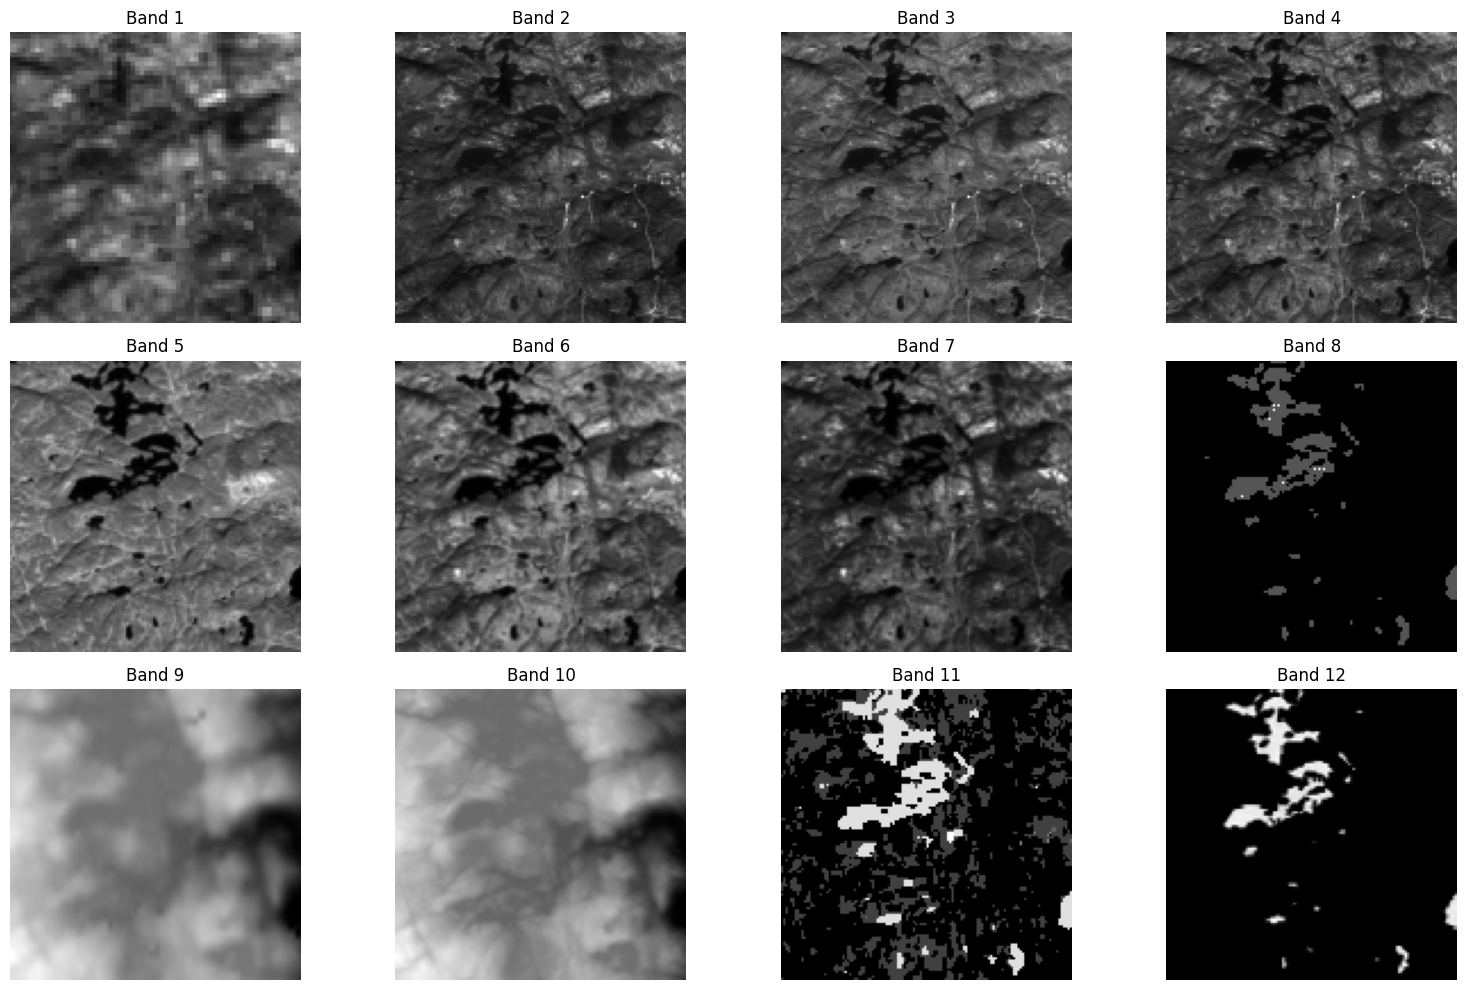

In [44]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model Arch

In [45]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


### Testing Diffrent Channels 

In [46]:
bands_A = list(range(12))
bands_B = [0, 1, 4, 5, 6, 11]
bands_C = [3, 2, 1]  # R,G,B
bands_D = [4, 5, 6]
bands_E = [0, 1, 4, 5, 6, 11]  # + NDWI computed later


In [47]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, add_ndwi=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.add_ndwi = add_ndwi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            image = src.read()

        image = np.transpose(image, (1,2,0)).astype(np.float32)

        image = image[:, :, self.selected_bands]

        if self.add_ndwi:
            green = image[:, :, 2] if 2 in self.selected_bands else image[:, :, 1]
            nir = image[:, :, 4] if 4 in self.selected_bands else image[:, :, -1]

            ndwi = (green - nir) / (green + nir + 1e-8)
            ndwi = np.expand_dims(ndwi, axis=-1)

            image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [ ]:
def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()

In [52]:
def train_model(selected_bands, add_ndwi=False, epochs=20):

    dataset = WaterDataset(image_dir, label_dir, selected_bands, add_ndwi)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    in_channels = len(selected_bands) + (1 if add_ndwi else 0)
    model = UNet(in_channels=in_channels, out_channels=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []
    train_ious, val_ious = [], []

    for epoch in range(epochs):

        # ---------------- TRAIN ----------------
        model.train()
        train_loss = 0
        train_iou = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            train_iou += iou

            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        train_losses.append(train_loss)
        train_ious.append(train_iou)


        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        val_iou = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()

                iou, dice = calculate_metrics(preds, masks)
                val_iou += iou

                val_bar.set_postfix(val_loss=loss.item())

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        val_losses.append(val_loss)
        val_ious.append(val_iou)

        print(f"\nEpoch {epoch+1}")
        print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
        print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}")

    return {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_ious": train_ious,
        "val_ious": val_ious,
    }


In [53]:
results = {}

print("\n" + "="*60)
print("Training Model: All 12 Bands")
print("="*60)
results["All 12"] = train_model(bands_A)

print("\n" + "="*60)
print("Training Model: 6 Water Bands")
print("="*60)
results["6 Water Bands"] = train_model(bands_B)

print("\n" + "="*60)
print("Training Model: RGB")
print("="*60)
results["RGB"] = train_model(bands_C)

print("\n" + "="*60)
print("Training Model: NIR + SWIR")
print("="*60)
results["NIR+SWIR"] = train_model(bands_D)

print("\n" + "="*60)
print("Training Model: 6 Bands + NDWI")
print("="*60)
results["6 Bands + NDWI"] = train_model(bands_B, add_ndwi=True)



Training Model: All 12 Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.687]



Epoch 1
Train -> Loss:0.6456 | IoU:0.3916
Val   -> Loss:0.6747 | IoU:0.0775


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s, val_loss=0.617]



Epoch 2
Train -> Loss:0.5142 | IoU:0.5359
Val   -> Loss:0.6112 | IoU:0.0629


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.597]



Epoch 3
Train -> Loss:0.4624 | IoU:0.5426
Val   -> Loss:0.5964 | IoU:0.0629


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.632]



Epoch 4
Train -> Loss:0.4286 | IoU:0.5782
Val   -> Loss:0.6277 | IoU:0.0629


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s, val_loss=0.659]



Epoch 5
Train -> Loss:0.4386 | IoU:0.5320
Val   -> Loss:0.6499 | IoU:0.0629


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.602]



Epoch 6
Train -> Loss:0.4061 | IoU:0.6116
Val   -> Loss:0.6050 | IoU:0.0629


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s, val_loss=0.655]



Epoch 7
Train -> Loss:0.3958 | IoU:0.6006
Val   -> Loss:0.6462 | IoU:0.0629


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.656]



Epoch 8
Train -> Loss:0.3725 | IoU:0.6160
Val   -> Loss:0.6460 | IoU:0.0629


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s, val_loss=0.601]



Epoch 9
Train -> Loss:0.3655 | IoU:0.6278
Val   -> Loss:0.5993 | IoU:0.0629


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.612]



Epoch 10
Train -> Loss:0.3695 | IoU:0.5897
Val   -> Loss:0.6086 | IoU:0.0629


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.638]



Epoch 11
Train -> Loss:0.3534 | IoU:0.6088
Val   -> Loss:0.6324 | IoU:0.0629


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.657]



Epoch 12
Train -> Loss:0.3456 | IoU:0.6355
Val   -> Loss:0.6527 | IoU:0.0624


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s, val_loss=0.502]



Epoch 13
Train -> Loss:0.3412 | IoU:0.6424
Val   -> Loss:0.5391 | IoU:0.0610


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s, val_loss=0.558]



Epoch 14
Train -> Loss:0.3231 | IoU:0.6762
Val   -> Loss:0.5677 | IoU:0.0629


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, val_loss=0.509]



Epoch 15
Train -> Loss:0.3308 | IoU:0.6377
Val   -> Loss:0.5388 | IoU:0.0629


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s, val_loss=0.563]



Epoch 16
Train -> Loss:0.3519 | IoU:0.5553
Val   -> Loss:0.5679 | IoU:0.0629


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.615]



Epoch 17
Train -> Loss:0.3255 | IoU:0.6317
Val   -> Loss:0.6106 | IoU:0.0629


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, val_loss=0.564]



Epoch 18
Train -> Loss:0.3277 | IoU:0.6461
Val   -> Loss:0.5692 | IoU:0.0629


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.63it/s, val_loss=0.523]



Epoch 19
Train -> Loss:0.3243 | IoU:0.6551
Val   -> Loss:0.5406 | IoU:0.0629


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, val_loss=0.562]



Epoch 20
Train -> Loss:0.3124 | IoU:0.6570
Val   -> Loss:0.5660 | IoU:0.0629

Training Model: 6 Water Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.673]



Epoch 1
Train -> Loss:0.5212 | IoU:0.4529
Val   -> Loss:0.6723 | IoU:0.3372


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, val_loss=0.501]



Epoch 2
Train -> Loss:0.4035 | IoU:0.5923
Val   -> Loss:0.5047 | IoU:0.4194


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.383]



Epoch 3
Train -> Loss:0.3591 | IoU:0.6321
Val   -> Loss:0.3699 | IoU:0.6556


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.365]



Epoch 4
Train -> Loss:0.3407 | IoU:0.6387
Val   -> Loss:0.3346 | IoU:0.6546


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, val_loss=0.392]



Epoch 5
Train -> Loss:0.3298 | IoU:0.6409
Val   -> Loss:0.3545 | IoU:0.6583


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.379]



Epoch 6
Train -> Loss:0.3222 | IoU:0.6349
Val   -> Loss:0.3375 | IoU:0.7021


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.373]



Epoch 7
Train -> Loss:0.3119 | IoU:0.6458
Val   -> Loss:0.3272 | IoU:0.7102


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.346]



Epoch 8
Train -> Loss:0.3025 | IoU:0.6700
Val   -> Loss:0.3020 | IoU:0.7099


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.348]



Epoch 9
Train -> Loss:0.2876 | IoU:0.6965
Val   -> Loss:0.3084 | IoU:0.7113


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.365]



Epoch 10
Train -> Loss:0.2894 | IoU:0.6687
Val   -> Loss:0.3147 | IoU:0.7133


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.343]



Epoch 11
Train -> Loss:0.2742 | IoU:0.7058
Val   -> Loss:0.2962 | IoU:0.7146


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s, val_loss=0.343]



Epoch 12
Train -> Loss:0.2681 | IoU:0.7080
Val   -> Loss:0.2945 | IoU:0.7126


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.383]



Epoch 13
Train -> Loss:0.2683 | IoU:0.6994
Val   -> Loss:0.3073 | IoU:0.7071


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.329]



Epoch 14
Train -> Loss:0.2733 | IoU:0.6850
Val   -> Loss:0.2830 | IoU:0.7284


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.319]



Epoch 15
Train -> Loss:0.2548 | IoU:0.7202
Val   -> Loss:0.2830 | IoU:0.7175


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.378]



Epoch 16
Train -> Loss:0.2475 | IoU:0.7222
Val   -> Loss:0.3097 | IoU:0.7081


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s, val_loss=0.316]



Epoch 17
Train -> Loss:0.2376 | IoU:0.7448
Val   -> Loss:0.2701 | IoU:0.7330


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.304]



Epoch 18
Train -> Loss:0.2401 | IoU:0.7286
Val   -> Loss:0.2607 | IoU:0.7362


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.329]



Epoch 19
Train -> Loss:0.2358 | IoU:0.7414
Val   -> Loss:0.2816 | IoU:0.7302


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.339]



Epoch 20
Train -> Loss:0.2310 | IoU:0.7432
Val   -> Loss:0.2777 | IoU:0.7439

Training Model: RGB


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.749]



Epoch 1
Train -> Loss:0.5858 | IoU:0.3045
Val   -> Loss:0.7606 | IoU:0.2256


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=1.33]



Epoch 2
Train -> Loss:0.5187 | IoU:0.3828
Val   -> Loss:1.4041 | IoU:0.2255


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=1.19]



Epoch 3
Train -> Loss:0.5045 | IoU:0.3740
Val   -> Loss:1.1634 | IoU:0.2482


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.617]



Epoch 4
Train -> Loss:0.4779 | IoU:0.3787
Val   -> Loss:0.5450 | IoU:0.3614


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.441]



Epoch 5
Train -> Loss:0.4417 | IoU:0.4174
Val   -> Loss:0.4338 | IoU:0.3894


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s, val_loss=0.424]



Epoch 6
Train -> Loss:0.4232 | IoU:0.4271
Val   -> Loss:0.3911 | IoU:0.4033


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.477]



Epoch 7
Train -> Loss:0.4221 | IoU:0.4375
Val   -> Loss:0.4242 | IoU:0.4296


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.395]



Epoch 8
Train -> Loss:0.4091 | IoU:0.4426
Val   -> Loss:0.3794 | IoU:0.3630


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.37] 



Epoch 9
Train -> Loss:0.3853 | IoU:0.4747
Val   -> Loss:0.3522 | IoU:0.4724


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.28it/s, val_loss=0.385]



Epoch 10
Train -> Loss:0.3969 | IoU:0.4741
Val   -> Loss:0.3648 | IoU:0.4191


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.396]



Epoch 11
Train -> Loss:0.3995 | IoU:0.4449
Val   -> Loss:0.3591 | IoU:0.4466


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.36] 



Epoch 12
Train -> Loss:0.3783 | IoU:0.4889
Val   -> Loss:0.3557 | IoU:0.4414


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.438]



Epoch 13
Train -> Loss:0.3695 | IoU:0.5184
Val   -> Loss:0.3818 | IoU:0.5282


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.38] 



Epoch 14
Train -> Loss:0.3635 | IoU:0.5198
Val   -> Loss:0.3695 | IoU:0.4476


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.385]



Epoch 15
Train -> Loss:0.3882 | IoU:0.4579
Val   -> Loss:0.3681 | IoU:0.4570


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s, val_loss=0.359]



Epoch 16
Train -> Loss:0.3753 | IoU:0.5052
Val   -> Loss:0.3344 | IoU:0.4861


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.422]



Epoch 17
Train -> Loss:0.3424 | IoU:0.5446
Val   -> Loss:0.3785 | IoU:0.5267


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s, val_loss=0.389]



Epoch 18
Train -> Loss:0.3633 | IoU:0.5156
Val   -> Loss:0.3693 | IoU:0.4358


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.359]



Epoch 19
Train -> Loss:0.3522 | IoU:0.5198
Val   -> Loss:0.3450 | IoU:0.4521


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.372]



Epoch 20
Train -> Loss:0.3823 | IoU:0.5150
Val   -> Loss:0.3693 | IoU:0.4477

Training Model: NIR + SWIR


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s, val_loss=0.683]



Epoch 1
Train -> Loss:0.5869 | IoU:0.4558
Val   -> Loss:0.6824 | IoU:0.4694


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.582]



Epoch 2
Train -> Loss:0.4558 | IoU:0.5954
Val   -> Loss:0.5810 | IoU:0.2602


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s, val_loss=0.484]



Epoch 3
Train -> Loss:0.4423 | IoU:0.5860
Val   -> Loss:0.4712 | IoU:0.4975


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s, val_loss=0.438]



Epoch 4
Train -> Loss:0.4201 | IoU:0.6070
Val   -> Loss:0.4040 | IoU:0.5509


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.412]



Epoch 5
Train -> Loss:0.4096 | IoU:0.5944
Val   -> Loss:0.3823 | IoU:0.5741


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.467]



Epoch 6
Train -> Loss:0.3917 | IoU:0.6116
Val   -> Loss:0.4383 | IoU:0.5732


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s, val_loss=0.426]



Epoch 7
Train -> Loss:0.3866 | IoU:0.6298
Val   -> Loss:0.3992 | IoU:0.5743


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.412]



Epoch 8
Train -> Loss:0.3926 | IoU:0.5968
Val   -> Loss:0.3807 | IoU:0.5786


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.426]



Epoch 9
Train -> Loss:0.3708 | IoU:0.6298
Val   -> Loss:0.3919 | IoU:0.5760


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.425]



Epoch 10
Train -> Loss:0.3601 | IoU:0.6321
Val   -> Loss:0.3896 | IoU:0.5923


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s, val_loss=0.406]



Epoch 11
Train -> Loss:0.3706 | IoU:0.6455
Val   -> Loss:0.3747 | IoU:0.5954


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.409]



Epoch 12
Train -> Loss:0.3774 | IoU:0.6338
Val   -> Loss:0.3750 | IoU:0.5874


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.423]



Epoch 13
Train -> Loss:0.3483 | IoU:0.6386
Val   -> Loss:0.3899 | IoU:0.5762


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, val_loss=0.417]



Epoch 14
Train -> Loss:0.3466 | IoU:0.6360
Val   -> Loss:0.3974 | IoU:0.5653


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.375]



Epoch 15
Train -> Loss:0.3482 | IoU:0.6223
Val   -> Loss:0.3414 | IoU:0.5780


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.409]



Epoch 16
Train -> Loss:0.3352 | IoU:0.6461
Val   -> Loss:0.3716 | IoU:0.5910


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.412]



Epoch 17
Train -> Loss:0.3341 | IoU:0.6512
Val   -> Loss:0.3763 | IoU:0.5912


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, val_loss=0.468]



Epoch 18
Train -> Loss:0.3159 | IoU:0.6848
Val   -> Loss:0.4043 | IoU:0.5895


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, val_loss=0.381]



Epoch 19
Train -> Loss:0.3224 | IoU:0.6677
Val   -> Loss:0.3511 | IoU:0.6006


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.419]



Epoch 20
Train -> Loss:0.3080 | IoU:0.6852
Val   -> Loss:0.3638 | IoU:0.6150

Training Model: 6 Bands + NDWI


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.655]



Epoch 1
Train -> Loss:0.5516 | IoU:0.4633
Val   -> Loss:0.6593 | IoU:0.3304


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s, val_loss=0.451]



Epoch 2
Train -> Loss:0.4180 | IoU:0.6169
Val   -> Loss:0.4704 | IoU:0.3956


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s, val_loss=0.367]



Epoch 3
Train -> Loss:0.3905 | IoU:0.6151
Val   -> Loss:0.3652 | IoU:0.6020


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s, val_loss=0.346]



Epoch 4
Train -> Loss:0.3562 | IoU:0.6730
Val   -> Loss:0.3450 | IoU:0.6127


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s, val_loss=0.341]



Epoch 5
Train -> Loss:0.3508 | IoU:0.6571
Val   -> Loss:0.3588 | IoU:0.6125


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s, val_loss=0.318]



Epoch 6
Train -> Loss:0.3419 | IoU:0.6600
Val   -> Loss:0.3297 | IoU:0.6282


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.343]



Epoch 7
Train -> Loss:0.3365 | IoU:0.6584
Val   -> Loss:0.3456 | IoU:0.6138


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.29it/s, val_loss=0.328]



Epoch 8
Train -> Loss:0.3374 | IoU:0.6374
Val   -> Loss:0.3372 | IoU:0.6314


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.343]



Epoch 9
Train -> Loss:0.3229 | IoU:0.6584
Val   -> Loss:0.3585 | IoU:0.5895


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s, val_loss=0.296]



Epoch 10
Train -> Loss:0.3162 | IoU:0.6622
Val   -> Loss:0.3043 | IoU:0.6238


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.317]



Epoch 11
Train -> Loss:0.3087 | IoU:0.6799
Val   -> Loss:0.3236 | IoU:0.6039


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.298]



Epoch 12
Train -> Loss:0.3005 | IoU:0.6838
Val   -> Loss:0.3086 | IoU:0.6299


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.301]



Epoch 13
Train -> Loss:0.2996 | IoU:0.6872
Val   -> Loss:0.3014 | IoU:0.6378


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s, val_loss=0.286]



Epoch 14
Train -> Loss:0.3025 | IoU:0.6741
Val   -> Loss:0.2910 | IoU:0.6431


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s, val_loss=0.313]



Epoch 15
Train -> Loss:0.2791 | IoU:0.7135
Val   -> Loss:0.3083 | IoU:0.6261


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, val_loss=0.308]



Epoch 16
Train -> Loss:0.2840 | IoU:0.6854
Val   -> Loss:0.3120 | IoU:0.6104


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s, val_loss=0.292]



Epoch 17
Train -> Loss:0.3029 | IoU:0.6650
Val   -> Loss:0.2835 | IoU:0.6344


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.272]



Epoch 18
Train -> Loss:0.2813 | IoU:0.6910
Val   -> Loss:0.2828 | IoU:0.6632


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s, val_loss=0.259]



Epoch 19
Train -> Loss:0.2775 | IoU:0.7006
Val   -> Loss:0.2829 | IoU:0.6356


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.261]


Epoch 20
Train -> Loss:0.2668 | IoU:0.7033
Val   -> Loss:0.2742 | IoU:0.6245


In [ ]:
print("\n" + "="*60)
print("Final Validation IoU Comparison")
print("="*60)

sorted_results = sorted(
    results.items(),
    key=lambda x: x[1]["val_ious"][-1],  
    reverse=True
)

for i, (name, data) in enumerate(sorted_results, 1):
    final_iou = data["val_ious"][-1]
    print(f"{i}. {name:<20} | IoU: {final_iou:.4f}")



Final Validation IoU Comparison
1. 6 Water Bands        | IoU: 0.7439
2. 6 Bands + NDWI       | IoU: 0.6245
3. NIR+SWIR             | IoU: 0.6150
4. RGB                  | IoU: 0.4477
5. All 12               | IoU: 0.0629


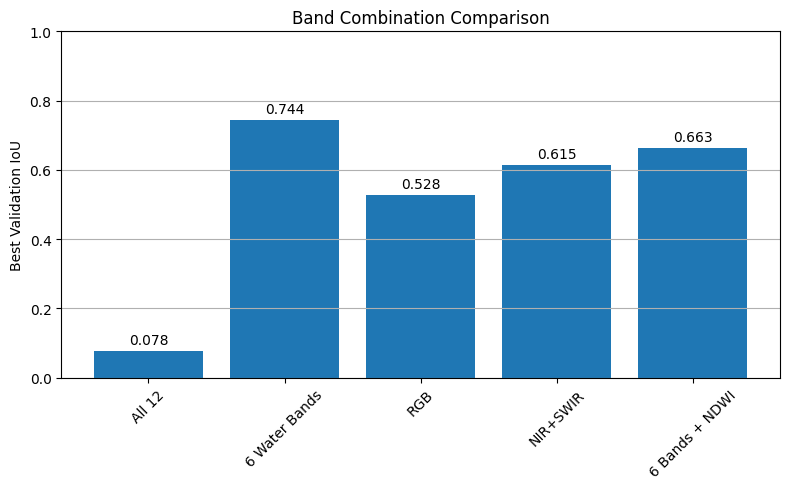

In [57]:
model_names = []
iou_scores = []

for name, data in results.items():
    best_iou = max(data["val_ious"])   # best validation IoU
    model_names.append(name)
    iou_scores.append(best_iou)

plt.figure(figsize=(8,5))
plt.bar(model_names, iou_scores)

plt.xticks(rotation=45)
plt.ylabel("Best Validation IoU")
plt.title("Band Combination Comparison")
plt.ylim(0, 1)
plt.grid(axis="y")

for i, v in enumerate(iou_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

### Model A (6 Bands)

In [58]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


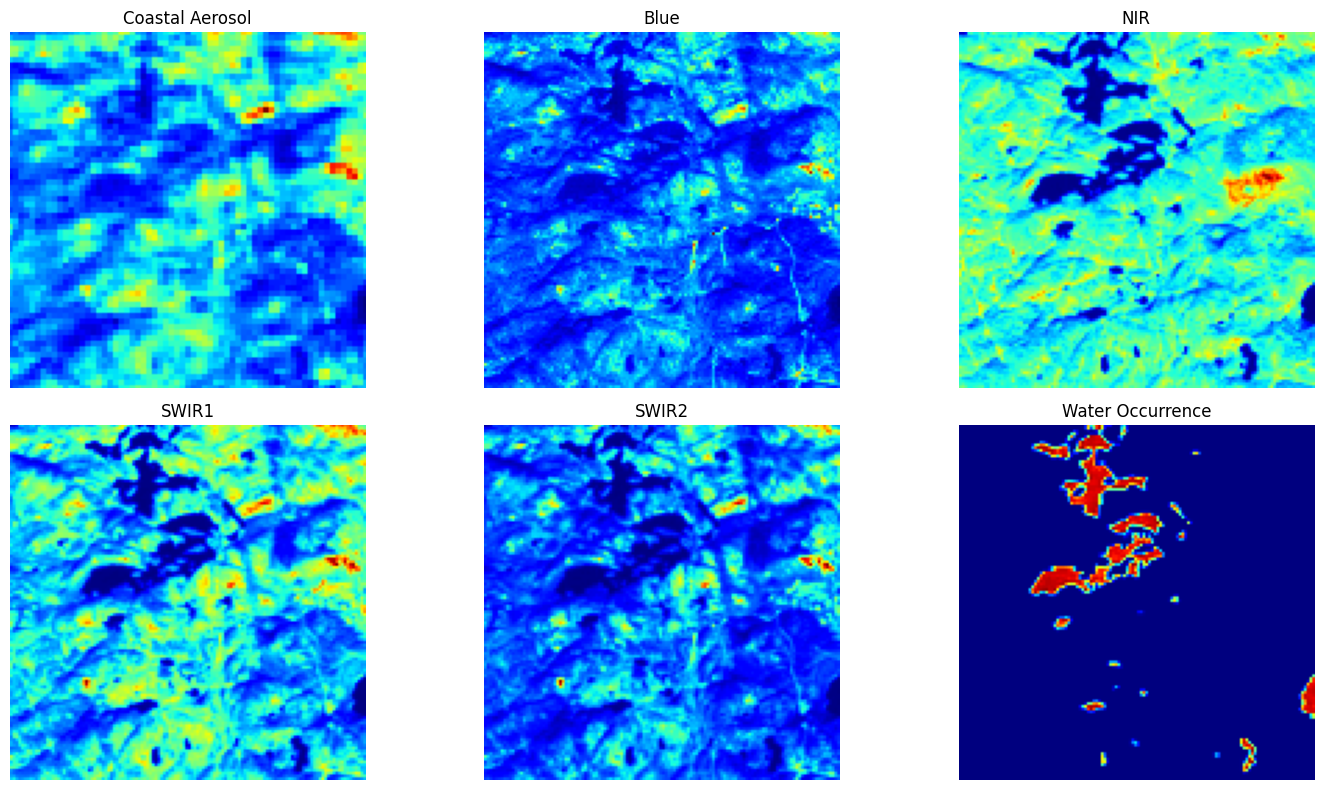

In [59]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [60]:
from torch.utils.data import Subset

dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



In [61]:
model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [65]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return iou.item(), dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou, dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)

            val_iou += iou

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")



Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.64it/s, val_loss=0.28] 



Epoch 1
Train -> Loss:0.3012 | IoU:0.6431
Val   -> Loss:0.2928 | IoU:0.7140



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s, val_loss=0.303]



Epoch 2
Train -> Loss:0.3092 | IoU:0.6187
Val   -> Loss:0.3004 | IoU:0.7225



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s, val_loss=0.257]



Epoch 3
Train -> Loss:0.2952 | IoU:0.6401
Val   -> Loss:0.2631 | IoU:0.7993



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.71it/s, val_loss=0.243]



Epoch 4
Train -> Loss:0.2759 | IoU:0.6727
Val   -> Loss:0.2511 | IoU:0.8081



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.237]



Epoch 5
Train -> Loss:0.2690 | IoU:0.6848
Val   -> Loss:0.2347 | IoU:0.8058



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.218]



Epoch 6
Train -> Loss:0.2741 | IoU:0.6619
Val   -> Loss:0.2439 | IoU:0.7356



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s, val_loss=0.245]



Epoch 7
Train -> Loss:0.2622 | IoU:0.6897
Val   -> Loss:0.2457 | IoU:0.8075



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s, val_loss=0.209]



Epoch 8
Train -> Loss:0.2434 | IoU:0.7271
Val   -> Loss:0.2421 | IoU:0.7277



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.201]



Epoch 9
Train -> Loss:0.2496 | IoU:0.7084
Val   -> Loss:0.2251 | IoU:0.7685



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.207]



Epoch 10
Train -> Loss:0.2457 | IoU:0.7121
Val   -> Loss:0.2290 | IoU:0.7556



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, val_loss=0.222]



Epoch 11
Train -> Loss:0.2412 | IoU:0.7027
Val   -> Loss:0.2362 | IoU:0.7831



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, val_loss=0.359]



Epoch 12
Train -> Loss:0.2390 | IoU:0.6966
Val   -> Loss:0.3099 | IoU:0.7361



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.19] 



Epoch 13
Train -> Loss:0.2356 | IoU:0.7128
Val   -> Loss:0.2321 | IoU:0.7145



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=0.209]



Epoch 14
Train -> Loss:0.2234 | IoU:0.7442
Val   -> Loss:0.2182 | IoU:0.7941



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.228]



Epoch 15
Train -> Loss:0.2116 | IoU:0.7562
Val   -> Loss:0.2435 | IoU:0.7423



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.192]



Epoch 16
Train -> Loss:0.2138 | IoU:0.7469
Val   -> Loss:0.2035 | IoU:0.8249



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.48it/s, val_loss=0.229]



Epoch 17
Train -> Loss:0.2027 | IoU:0.7658
Val   -> Loss:0.2213 | IoU:0.8236



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.179]



Epoch 18
Train -> Loss:0.2106 | IoU:0.7566
Val   -> Loss:0.2138 | IoU:0.7405



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s, val_loss=0.307]



Epoch 19
Train -> Loss:0.2235 | IoU:0.7246
Val   -> Loss:0.2963 | IoU:0.7471



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, val_loss=0.18] 


Epoch 20
Train -> Loss:0.2174 | IoU:0.7198
Val   -> Loss:0.2138 | IoU:0.7602



In [66]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Eval:
Precision: 0.7899
Recall:    0.8638
IoU:       0.7024
F1-score:  0.8252


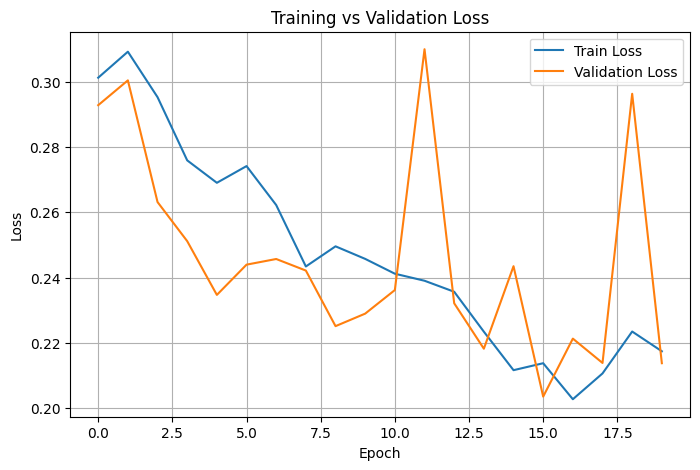

In [67]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


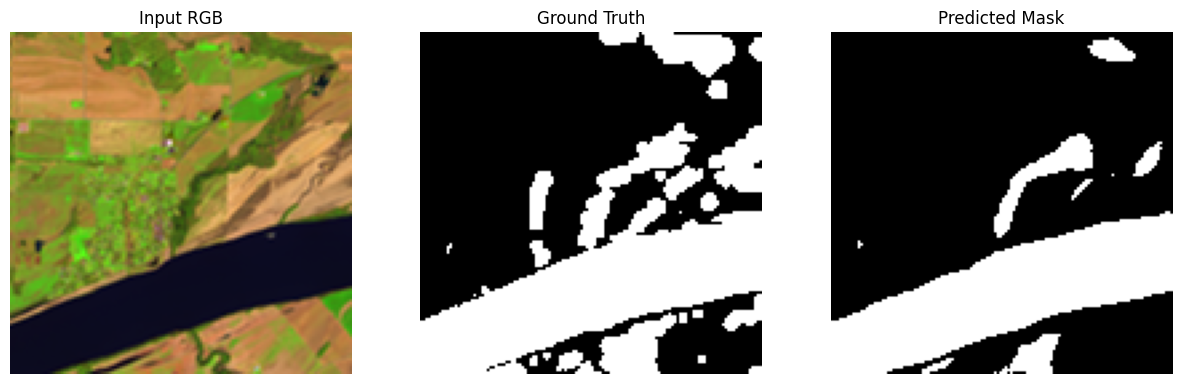

In [68]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


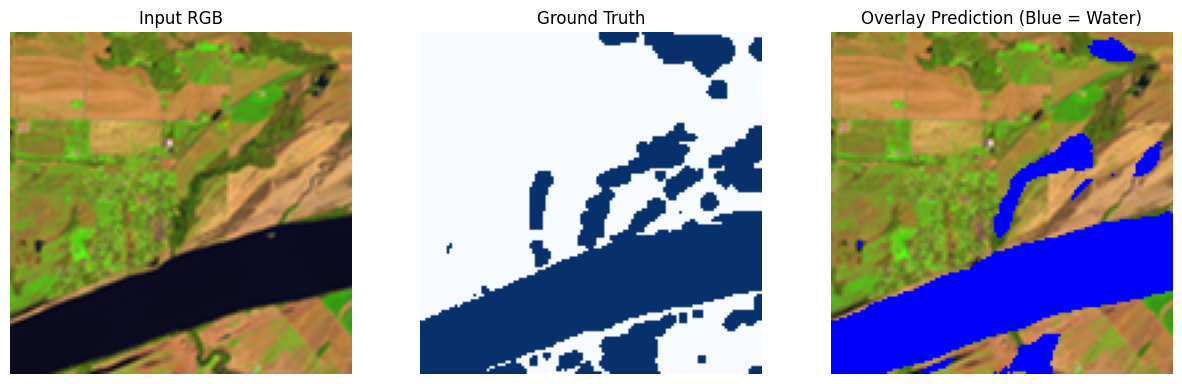

In [69]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model B (6 Bands + NDWI)

In [70]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [0, 1, 4, 5, 6, 11]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]

        green = full_image[:, :, 2]
        nir = full_image[:, :, 4]

        ndwi = (green - nir) / (green + nir + 1e-8)
        ndwi = np.expand_dims(ndwi, axis=-1)
        image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=7, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [72]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [73]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return iou.item(), dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou, dice = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)


    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            val_iou += iou


            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)


    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.631]



Epoch 1
Train -> Loss:0.5321 | IoU:0.4870
Val   -> Loss:0.6325 | IoU:0.1990



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.505]



Epoch 2
Train -> Loss:0.4121 | IoU:0.6137
Val   -> Loss:0.4865 | IoU:0.4656



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s, val_loss=0.4]  



Epoch 3
Train -> Loss:0.3791 | IoU:0.6312
Val   -> Loss:0.3685 | IoU:0.6235



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.364]



Epoch 4
Train -> Loss:0.3639 | IoU:0.6487
Val   -> Loss:0.3291 | IoU:0.6616



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.35] 



Epoch 5
Train -> Loss:0.3410 | IoU:0.6731
Val   -> Loss:0.3224 | IoU:0.6676



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.365]



Epoch 6
Train -> Loss:0.3465 | IoU:0.6442
Val   -> Loss:0.3415 | IoU:0.6587



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.351]



Epoch 7
Train -> Loss:0.3249 | IoU:0.6774
Val   -> Loss:0.3223 | IoU:0.6831



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s, val_loss=0.356]



Epoch 8
Train -> Loss:0.3158 | IoU:0.6722
Val   -> Loss:0.3273 | IoU:0.6768



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.336]



Epoch 9
Train -> Loss:0.3131 | IoU:0.6707
Val   -> Loss:0.3394 | IoU:0.6458



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s, val_loss=0.328]



Epoch 10
Train -> Loss:0.3149 | IoU:0.6593
Val   -> Loss:0.2889 | IoU:0.6732



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.347]



Epoch 11
Train -> Loss:0.3010 | IoU:0.6822
Val   -> Loss:0.3392 | IoU:0.6542



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.325]



Epoch 12
Train -> Loss:0.2850 | IoU:0.7139
Val   -> Loss:0.2898 | IoU:0.6965



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.353]



Epoch 13
Train -> Loss:0.2821 | IoU:0.7032
Val   -> Loss:0.3142 | IoU:0.7076



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s, val_loss=0.329]



Epoch 14
Train -> Loss:0.2799 | IoU:0.7203
Val   -> Loss:0.2882 | IoU:0.6940



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, val_loss=0.318]



Epoch 15
Train -> Loss:0.2783 | IoU:0.7106
Val   -> Loss:0.2768 | IoU:0.7075



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.04it/s, val_loss=0.321]



Epoch 16
Train -> Loss:0.2699 | IoU:0.7231
Val   -> Loss:0.2581 | IoU:0.7050



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s, val_loss=0.322]



Epoch 17
Train -> Loss:0.2603 | IoU:0.7275
Val   -> Loss:0.2609 | IoU:0.7038



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.331]



Epoch 18
Train -> Loss:0.2553 | IoU:0.7304
Val   -> Loss:0.3051 | IoU:0.6935



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.3]  



Epoch 19
Train -> Loss:0.2666 | IoU:0.7179
Val   -> Loss:0.2632 | IoU:0.7118



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s, val_loss=0.326]


Epoch 20
Train -> Loss:0.2477 | IoU:0.7401
Val   -> Loss:0.2723 | IoU:0.7091



In [74]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Eval:
Precision: 0.5900
Recall:    0.9175
IoU:       0.5603
F1-score:  0.7182


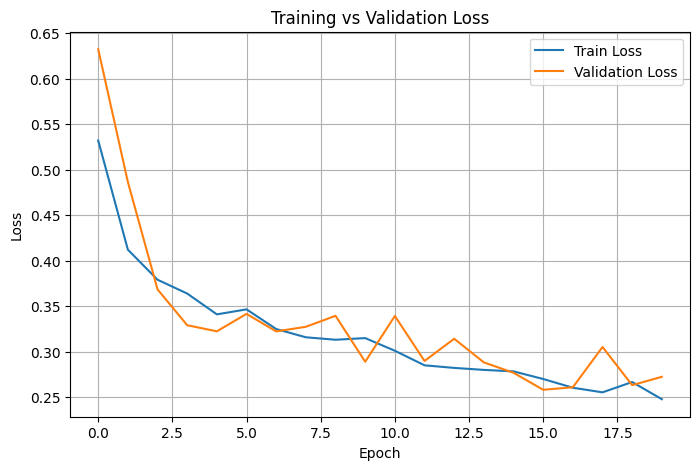

In [75]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


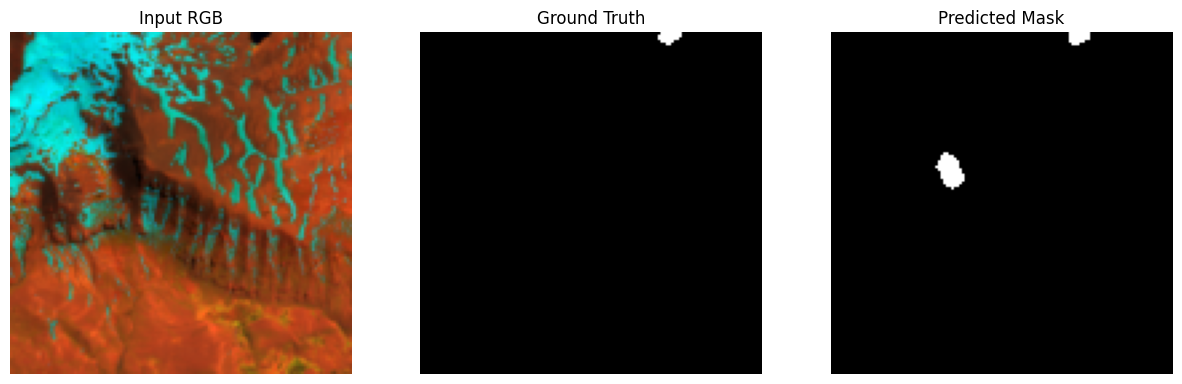

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


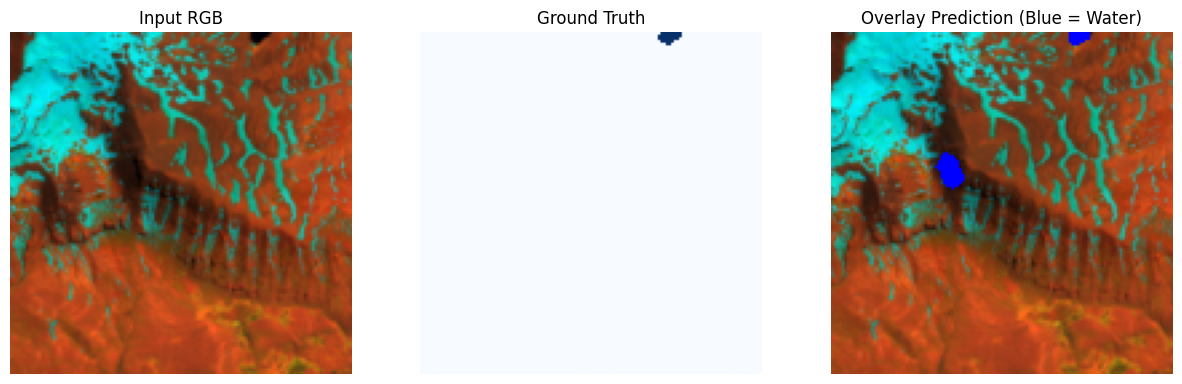

In [77]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()
